In [4]:
# Import packages
import numpy as np
import torch
import json

from source.models import MODEL_FACTORY
from utils.utils import get_device
from pytoda.datasets import (
    DrugAffinityDataset, ProteinProteinInteractionDataset
)
from pytoda.proteins import ProteinFeatureLanguage, ProteinLanguage
from pytoda.smiles.smiles_language import SMILESTokenizer

from sklearn.metrics import (
    auc, average_precision_score, precision_recall_curve, roc_curve
)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

device = get_device()

In [6]:
# Read in data
data_path = 'data/raw/'
model = 'results/models/'

tcrs = os.path.join(data_path, 'tcr_full.csv')
epitopes = os.path.join(data_path, 'epitopes.smi')
test_data = os.path.join(data_path, 'test.csv')
model_path = os.path.join(model, 'trained_small')

In [7]:
# Process parameter file:
params_filepath = os.path.join(model_path, 'model_params.json')
params = {}
with open(params_filepath) as fp:
    params.update(json.load(fp))

In [8]:
# Load languages
smiles_language = SMILESTokenizer.from_pretrained(model_path)
smiles_language.set_encoding_transforms(
    randomize=None,
    add_start_and_stop=params.get('ligand_start_stop_token', True),
    padding=params.get('ligand_padding', True),
    padding_length=params.get('ligand_padding_length', True),
)
smiles_language.set_smiles_transforms(
    augment=False,
)
if params.get('receptor_embedding', 'learned') == 'predefined':
    protein_language = ProteinFeatureLanguage.load(
        os.path.join(model_path, 'protein_language.pkl')
    )
else:
    protein_language = ProteinLanguage.load(
        os.path.join(model_path, 'protein_language.pkl')
    )

In [ ]:
# Load the data
test_dataset = DrugAffinityDataset(
    drug_affinity_filepath=test_data,
    smi_filepath=epitopes,
    protein_filepath=tcrs,
    smiles_language=smiles_language,
    protein_language=protein_language,
    smiles_padding=params.get('ligand_padding', True),
    smiles_padding_length=params.get('ligand_padding_length', None),
    smiles_add_start_and_stop=params.get(
        'ligand_add_start_stop', True
    ),
    protein_padding=params.get('receptor_padding', True),
    protein_padding_length=params.get('receptor_padding_length', None),
    protein_add_start_and_stop=params.get(
        'receptor_add_start_stop', True
    ),
    drug_affinity_dtype=torch.float,
    backend='eager',
    iterate_dataset=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=10,
    shuffle=False,
    drop_last=False,
    num_workers=params.get('num_workers', 0)
)

In [ ]:
# Load the Model
model_fn = params.get('model_fn')
model = MODEL_FACTORY[model_fn](params).to(device)
model._associate_language(smiles_language)
model._associate_language(protein_language)

# Choose the weights among already trained models
model_file = os.path.join(
    model_path, 'weights', 'done_training_model.pt'
)


if os.path.isfile(model_file):
    print('Found existing model, restoring now...')
    model.load(model_file, map_location=device)
    print(f'model loaded: {model_file}')

In [11]:
# Measure validation performance
loss_validation = []
model.eval()
with torch.no_grad():
    test_loss = 0
    predictions = []
    labels = []
    tcr_attention = []
    tcr_id = []
    for ind, (ligand, receptors, y) in enumerate(test_loader):
        y_hat, pred_dict = model(ligand.to(device), receptors.to(device))
        predictions.append(y_hat)
        labels.append(y.clone())
        loss = model.loss(y_hat, y.to(device))
        test_loss += loss.item()
        tcr_attention.append(pred_dict['receptor_attention'])
        tcr_id.append(receptors)

predictions = torch.cat(predictions, dim=0).flatten().cpu().numpy()
labels = torch.cat(labels, dim=0).flatten().cpu().numpy()
loss_validation.append(test_loss / len(test_loader))
tcr_attention = torch.cat(tcr_attention, dim=0).cpu().numpy()
tcr_id = torch.cat(tcr_id, dim=0).cpu().numpy()

test_loss = test_loss / len(test_loader)
fpr, tpr, _ = roc_curve(labels, predictions)
precision, recall, _ = precision_recall_curve(labels, predictions)
test_roc_auc = auc(fpr, tpr)
print('ROC AUC', test_roc_auc)

ROC AUC 0.7510430758276967


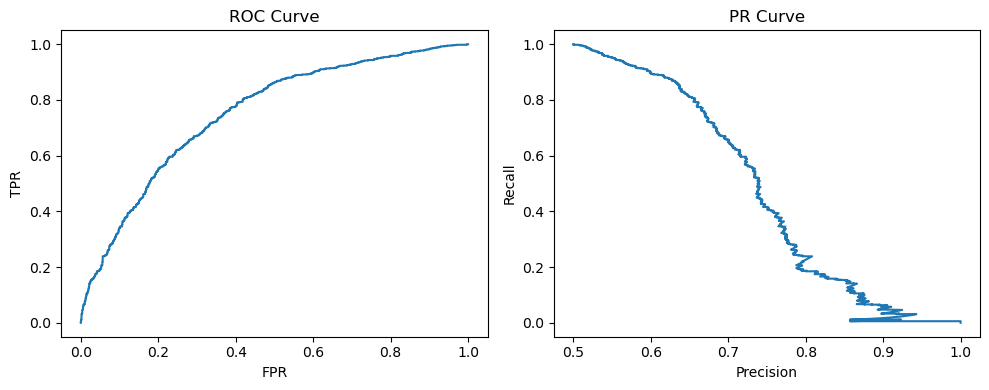

In [12]:
# Plot Evaluation Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(fpr, tpr)
ax1.set_title('ROC Curve')
ax1.set_ylabel('TPR')
ax1.set_xlabel('FPR')
ax2.plot(precision, recall)
ax2.set_title('PR Curve')
ax2.set_ylabel('Recall')
ax2.set_xlabel('Precision')
plt.tight_layout()

In [13]:
def find_colors(attention, text):
    normalize = mpl.colors.Normalize(
            vmin=min(attention),
            vmax=max(attention)
        )

    color_mapper = cm.ScalarMappable(
        norm=normalize, cmap=plt.cm.Oranges
    )

    colors = color_mapper.to_rgba(attention, alpha=1.)
    if text:
        colors = [(x[0]*255,x[1]*255,x[2]*255) for x in colors]
    return(colors)

In [14]:
from IPython.core.display import display, HTML
import html 

def html_escape(text):
    return html.escape(text)

def highlight_text(text, colors, start_underline, end_underline):
    highlighted_text = []
    for i in range(len(text)):
        if i in start_underline:
            highlighted_text.append('<u>'
                                    +'<span style="font-family:courier; background-color:rgba(' 
                                    + str(int(colors[i][0])) + ','
                                    + str(int(colors[i][1])) + ','
                                    + str(int(colors[i][2])) + ');">' 
                                    + html_escape(text[i])
                                    + '</span>')
        elif i in end_underline:
            highlighted_text.append('<span style="font-family:courier; background-color:rgba(' 
                                    + str(int(colors[i][0])) + ','
                                    + str(int(colors[i][1])) + ','
                                    + str(int(colors[i][2])) + ');">' 
                                    + html_escape(text[i])
                                    + '</span>'
                                    + '</u>')
        else:
            highlighted_text.append('<span style="font-family:courier;background-color:rgba(' 
                                + str(int(colors[i][0])) + ','
                                + str(int(colors[i][1])) + ','
                                + str(int(colors[i][2])) + ');">' 
                                + html_escape(text[i])
                                + '</span>')
    highlighted_text = ' '.join(highlighted_text)
    return highlighted_text

/var/folders/gl/rntzzrtx61q4kv7fgrstdv4c0000gn/T/ipykernel_18728/1756082082.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [15]:
show_aas = 50
cutoff = 130-show_aas

In [16]:
# Extract Attention Scores
tokens = []
for i in range(len(tcr_id)):
    t = []
    for i,x in enumerate(tcr_id[i]):
        if i > cutoff:
            if protein_language.index_to_token[x] == '<PAD>':
                token = '0'
            elif protein_language.index_to_token[x] == '<START>' or protein_language.index_to_token[x] == '<STOP>':
                token = '1'
            else:
                token = protein_language.index_to_token[x]
            t.append(token)
    tokens.append(t)

In [17]:
for i in [0,1,2,3,4,5,6,7]:
    seq  = ''.join(tokens[i])
    att = tcr_attention[i][cutoff:]
    col = find_colors(att, True)
    starts = []
    stops = []
    display(HTML(highlight_text(seq,  col, starts, stops)))